# Growth curve analysis of validation mutants

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['svg.fonttype'] = 'none'

## Specify paths

In [2]:
# Input
layout_path = '../growth_data/20240129_full_layout.tsv'
source_data = ['../growth_data/20240128_validations_DMS_control.xlsx',
               '../growth_data/20240128_validations_DMS_caspo.xlsx',
               '../growth_data/20240131_validations_DMS_mica.xlsx',
               '../growth_data/20240131_validations_DMS_ani.xlsx']
DMS_data = '../classified/BY4741_FKS1-HS1/refined_classification.csv'

# Output
df_outpath = '../growth_data/'
graph_outpath = '../graphs/'

## Get layout

In [3]:
layout = pd.read_csv(layout_path, sep='\t', header=0, dtype={'Sanger_validated': 'boolean'})
layout

,plate,well,compound,aa_seq,genotype,clone,Sanger_validated
0,1,A1,none,LVLSLRDP,F639delta,2,False
1,1,B1,none,LVLSLRDP,F639delta,3,False
2,1,C1,none,FVLSLRDP,L40delta,3,False
3,1,D1,none,FVLSLRDP,L40delta,4,False
4,1,E1,none,FLLSLRDP,V641delta,3,False
...,...,...,...,...,...,...,...
315,4,D10,anidulafungin,QLVLSLRDP,F639Q,3,False
316,4,E10,anidulafungin,FLVLSLRDP,WT,1,True
317,4,F10,anidulafungin,FLVLSLRDP,WT,2,True
318,4,G10,anidulafungin,FLVLSLRDP,BY,1,True


In [4]:
print('Unique genotypes validated by Sanger:\n', layout.loc[layout.Sanger_validated, 'genotype'].unique())

Unique genotypes validated by Sanger:
 ['F639C' 'L640D' 'L642G' 'P647Q' 'P647N' 'F639V' 'F639S' 'L642Y' 'L642F'
 'S643P' 'S643F' 'S643Y' 'S643C' 'L640K' 'V641S' 'L640G' 'D646W' 'F639D'
 'F639E' 'V641F' 'V641H' 'L642K' 'S643L' 'R645D' 'R645S' 'V641W' 'R645Q'
 'F639Q' 'WT' 'BY']


## Get plate reader data

In [5]:
def get_data(fpath):
    ### Import libraries
    import numpy as np
    from datetime import datetime, date, time
    
    ### Read excel file
    source_df = pd.read_excel(fpath, index_col=0, header=0, skiprows=26, skipfooter=36)
    
    ### Parse timepoints
    t0, t1 = source_df.iloc[[0,1],0] # Get the first and second timepoints

    # Convert first timepoint from time (of the day) object to time duration (h)
    t0_h = (datetime.combine(date.today(), t0) - datetime.combine(date.today(), time.min)).total_seconds() / 3600

    # Convert difference between second and first timepoint into duration in h (measurement interval)
    delta = (datetime.combine(date.today(), t1) - datetime.combine(date.today(), t0)).total_seconds() / 3600

    # Rewrite column of timepoints using calculated values
    source_df['Time'] = np.arange(t0_h, t0_h + len(source_df.Time)*delta, delta)

    # Delete column with temperature
    source_df.drop(columns='T° 600', inplace=True)

    # Rename columns
    source_df.columns = [x.split('=')[-1] if '=' in x else x for x in source_df.columns]
    
    # Reshape
    longdf = source_df.melt(id_vars = 'Time', var_name = 'well', value_name = 'OD') # wide to long dataframe
    return longdf

In [6]:
df_list = []

for i,f in enumerate(source_data):
        df = get_data(f)
        df['plate'] = i+1
        df_list.append(df)

fulldf = pd.concat(df_list, ignore_index=True) 
fulldf

,Time,well,OD,plate
0,0.00,A1,0.116,1
1,0.25,A1,0.116,1
2,0.50,A1,0.117,1
3,0.75,A1,0.118,1
4,1.00,A1,0.119,1
...,...,...,...,...
110971,71.00,H12,NaN,4
110972,71.25,H12,NaN,4
110973,71.50,H12,NaN,4
110974,71.75,H12,NaN,4


## Annotate data

In [7]:
annotdf = fulldf.merge(right=layout[layout.Sanger_validated], on=['plate','well'])
annotdf

,Time,well,OD,plate,compound,aa_seq,genotype,clone,Sanger_validated
0,0.00,A4,0.118,1,none,FLVLSLRDQ,P647Q,2,True
1,0.25,A4,0.118,1,none,FLVLSLRDQ,P647Q,2,True
2,0.50,A4,0.119,1,none,FLVLSLRDQ,P647Q,2,True
3,0.75,A4,0.120,1,none,FLVLSLRDQ,P647Q,2,True
4,1.00,A4,0.122,1,none,FLVLSLRDQ,P647Q,2,True
...,...,...,...,...,...,...,...,...,...
57795,71.00,H10,NaN,4,anidulafungin,FLVLSLRDP,BY,2,True
57796,71.25,H10,NaN,4,anidulafungin,FLVLSLRDP,BY,2,True
57797,71.50,H10,NaN,4,anidulafungin,FLVLSLRDP,BY,2,True
57798,71.75,H10,NaN,4,anidulafungin,FLVLSLRDP,BY,2,True


## Visualize growth curves

```
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

grid = sns.FacetGrid(data=annotdf, col = 'compound', hue='genotype', palette='hls')
grid.map(sns.lineplot, 'Time', 'OD')

grid.set_titles(row_template='{row_name}', col_template='{col_name}')
grid.set_axis_labels('Time (h)', 'OD')
grid.add_legend(title = 'Genotype')
grid.fig.subplots_adjust(top=0.9)
grid.tight_layout()
```

## Calculate normalized area under the curve (AUC)

In [8]:
def get_auc(g):
    import numpy as np
    return np.trapezoid(g.OD)

In [9]:
aucdf = annotdf[annotdf['Time'] <= 40].groupby(['genotype','aa_seq','clone','compound','well'
                                                   ])[['OD']].apply(func=get_auc).reset_index(name='auc')
aucdf

,genotype,aa_seq,clone,compound,well,auc
0,BY,FLVLSLRDP,1,anidulafungin,G10,22.6925
1,BY,FLVLSLRDP,1,caspofungin,G10,21.9170
2,BY,FLVLSLRDP,1,micafungin,G10,21.3405
3,BY,FLVLSLRDP,1,none,G10,147.2240
4,BY,FLVLSLRDP,2,anidulafungin,H10,29.2160
...,...,...,...,...,...,...
195,WT,FLVLSLRDP,1,none,E10,144.9465
196,WT,FLVLSLRDP,2,anidulafungin,F10,24.2550
197,WT,FLVLSLRDP,2,caspofungin,F10,20.9890
198,WT,FLVLSLRDP,2,micafungin,F10,22.4110


In [10]:
aggdf = aucdf.groupby(['genotype','aa_seq','compound']
                     )[['auc']].agg(auc = ('auc', 'mean'),
                                    auc_min = ('auc', 'min'),
                                    auc_max = ('auc', 'max')
                                   ).reset_index()
aggdf.head(10)

,genotype,aa_seq,compound,auc,auc_min,auc_max
0,BY,FLVLSLRDP,anidulafungin,25.95425,22.6925,29.2160
1,BY,FLVLSLRDP,caspofungin,22.90100,21.9170,23.8850
2,BY,FLVLSLRDP,micafungin,24.07575,21.3405,26.8110
3,BY,FLVLSLRDP,none,134.43275,121.6415,147.2240
4,D646W,FLVLSLRWP,anidulafungin,122.99300,122.9930,122.9930
5,D646W,FLVLSLRWP,caspofungin,126.28600,126.2860,126.2860
6,D646W,FLVLSLRWP,micafungin,41.22150,41.2215,41.2215
7,D646W,FLVLSLRWP,none,142.10700,142.1070,142.1070
8,F639C,CLVLSLRDP,anidulafungin,143.19975,139.3225,147.0770
9,F639C,CLVLSLRDP,caspofungin,135.58750,132.0890,139.0860


In [11]:
def get_l2fc(val, minv, maxv, comp, df):    
    import numpy as np
    
    # Retrieve corresponding WT value for the condition
    wt = df.loc[(df.compound == comp)
                & (df.genotype == 'BY'),
                'auc'
               ].values
    
    # Make sure a single value was extracted
    if len(wt) == 1:
        # Return log2 fold-change for mean, min and max
        return np.log2(val/wt[0]), np.log2(minv/wt[0]), np.log2(maxv/wt[0])
    else:
        return 'error'

In [12]:
aggdf['L2FC'], aggdf['L2FC_min'], aggdf['L2FC_max'] = zip(*aggdf.apply(lambda row: get_l2fc(row.auc, row.auc_min, row.auc_max, row.compound, aggdf), axis=1))
aggdf.head(10)

,genotype,aa_seq,compound,auc,auc_min,auc_max,L2FC,L2FC_min,L2FC_max
0,BY,FLVLSLRDP,anidulafungin,25.95425,22.6925,29.2160,0.000000,-0.193755,0.170788
1,BY,FLVLSLRDP,caspofungin,22.90100,21.9170,23.8850,0.000000,-0.063360,0.060694
2,BY,FLVLSLRDP,micafungin,24.07575,21.3405,26.8110,0.000000,-0.173987,0.155244
3,BY,FLVLSLRDP,none,134.43275,121.6415,147.2240,0.000000,-0.144249,0.131128
4,D646W,FLVLSLRWP,anidulafungin,122.99300,122.9930,122.9930,2.244534,2.244534,2.244534
5,D646W,FLVLSLRWP,caspofungin,126.28600,126.2860,126.2860,2.463212,2.463212,2.463212
6,D646W,FLVLSLRWP,micafungin,41.22150,41.2215,41.2215,0.775816,0.775816,0.775816
7,D646W,FLVLSLRWP,none,142.10700,142.1070,142.1070,0.080093,0.080093,0.080093
8,F639C,CLVLSLRDP,anidulafungin,143.19975,139.3225,147.0770,2.463986,2.424386,2.502529
9,F639C,CLVLSLRDP,caspofungin,135.58750,132.0890,139.0860,2.565742,2.528028,2.602495


In [13]:
aggdf['min_yerr'] = aggdf['L2FC'] - aggdf['L2FC_min']
aggdf['max_yerr'] = aggdf['L2FC_max'] - aggdf['L2FC']
aggdf.head(10)

,genotype,aa_seq,compound,auc,auc_min,auc_max,L2FC,L2FC_min,L2FC_max,min_yerr,max_yerr
0,BY,FLVLSLRDP,anidulafungin,25.95425,22.6925,29.2160,0.000000,-0.193755,0.170788,0.193755,0.170788
1,BY,FLVLSLRDP,caspofungin,22.90100,21.9170,23.8850,0.000000,-0.063360,0.060694,0.063360,0.060694
2,BY,FLVLSLRDP,micafungin,24.07575,21.3405,26.8110,0.000000,-0.173987,0.155244,0.173987,0.155244
3,BY,FLVLSLRDP,none,134.43275,121.6415,147.2240,0.000000,-0.144249,0.131128,0.144249,0.131128
4,D646W,FLVLSLRWP,anidulafungin,122.99300,122.9930,122.9930,2.244534,2.244534,2.244534,0.000000,0.000000
5,D646W,FLVLSLRWP,caspofungin,126.28600,126.2860,126.2860,2.463212,2.463212,2.463212,0.000000,0.000000
6,D646W,FLVLSLRWP,micafungin,41.22150,41.2215,41.2215,0.775816,0.775816,0.775816,0.000000,0.000000
7,D646W,FLVLSLRWP,none,142.10700,142.1070,142.1070,0.080093,0.080093,0.080093,0.000000,0.000000
8,F639C,CLVLSLRDP,anidulafungin,143.19975,139.3225,147.0770,2.463986,2.424386,2.502529,0.039601,0.038543
9,F639C,CLVLSLRDP,caspofungin,135.58750,132.0890,139.0860,2.565742,2.528028,2.602495,0.037714,0.036753


## Visualize log2 fold changes

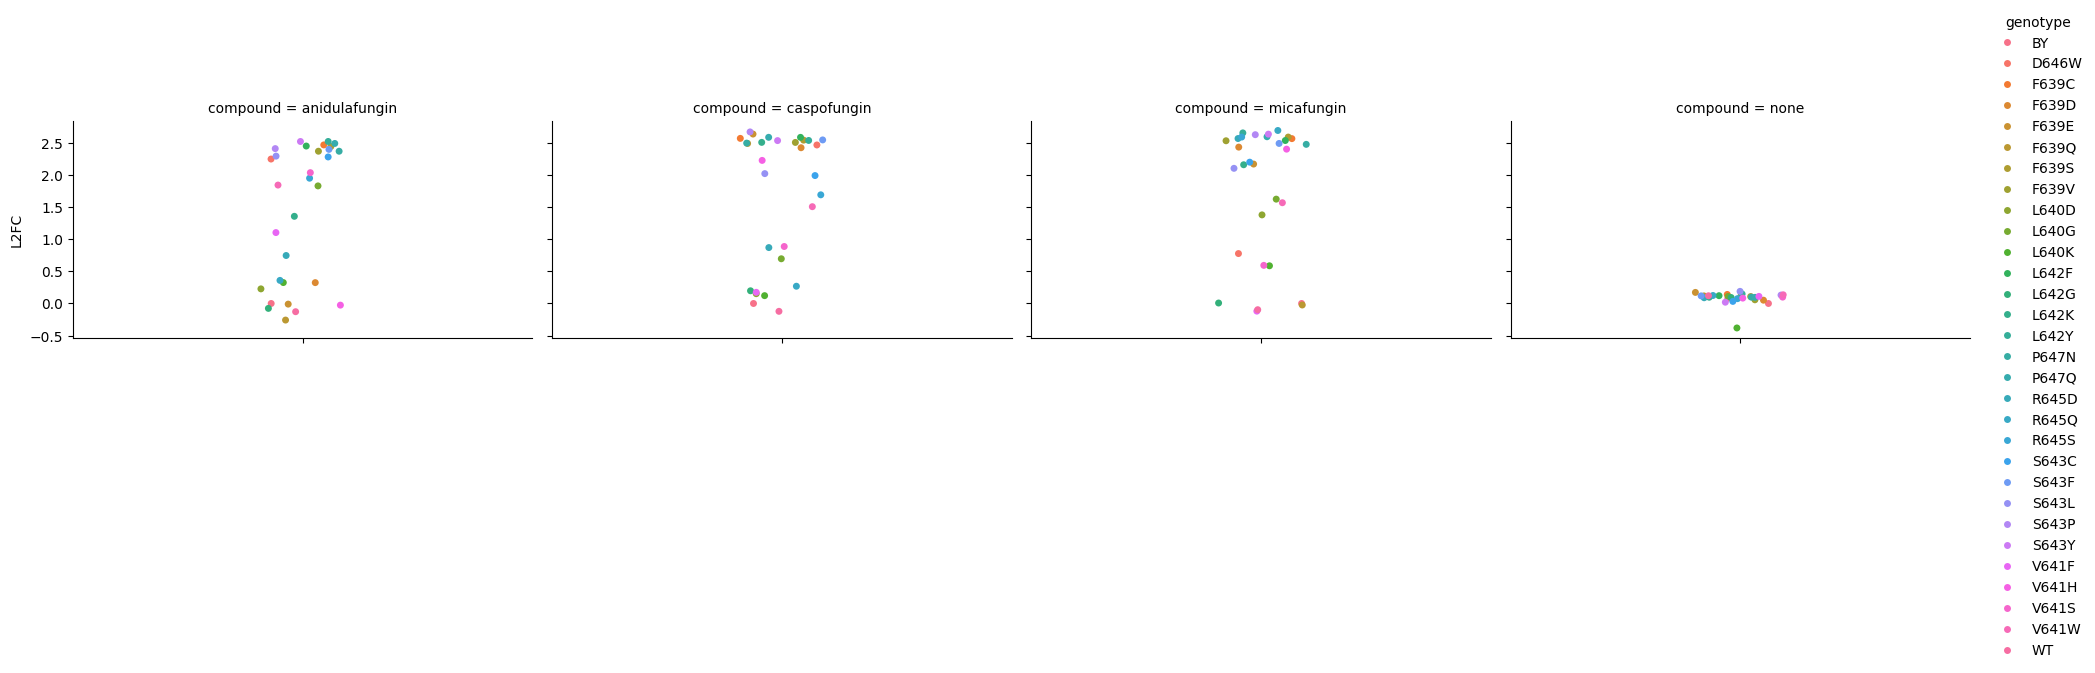

In [14]:
sns.catplot(aggdf, col='compound', y='L2FC', hue='genotype')

## Compare with DMS scores

In [15]:
DMS_aa = pd.read_csv(DMS_data, index_col=0).rename(columns={"min_s":"min_xerr", "max_s":"max_xerr"})
DMS_aa

,compound,aa_seq,s,min_xerr,max_xerr,label,rclass,refined_class,sensres
0,anidulafungin,*LVLSLRDP,0.166788,0.125238,0.125238,0.0,WT-like,WT-like,sensitive
1,anidulafungin,ALVLSLRDP,1.614675,0.112191,0.112191,2.0,intermediary,intermediary,resistant
2,anidulafungin,DLVLSLRDP,-0.044646,0.150571,0.150571,0.0,WT-like,WT-like,sensitive
3,anidulafungin,ELVLSLRDP,0.564251,0.089555,0.089555,2.0,intermediary,WT-like,sensitive
4,anidulafungin,F*VLSLRDP,0.134916,0.126564,0.126564,0.0,WT-like,WT-like,sensitive
...,...,...,...,...,...,...,...,...,...
683,none,SLVLSLRDP,0.009320,0.012019,0.012019,0.0,WT-like,WT-like,sensitive
684,none,TLVLSLRDP,-0.228853,0.073537,0.073537,1.0,slightly deleterious,slightly deleterious,sensitive
685,none,VLVLSLRDP,0.028834,0.013133,0.013133,0.0,WT-like,WT-like,sensitive
686,none,WLVLSLRDP,0.048208,0.010552,0.010552,0.0,WT-like,WT-like,sensitive


In [16]:
corrdf = aggdf.merge(right=DMS_aa, on=['compound', 'aa_seq'])
corrdf.head(10)

,genotype,aa_seq,compound,auc,auc_min,auc_max,L2FC,L2FC_min,L2FC_max,min_yerr,max_yerr,s,min_xerr,max_xerr,label,rclass,refined_class,sensres
0,BY,FLVLSLRDP,anidulafungin,25.95425,22.6925,29.2160,0.000000,-0.193755,0.170788,0.193755,0.170788,-0.090854,0.058192,0.058192,0.0,WT-like,WT-like,sensitive
1,BY,FLVLSLRDP,caspofungin,22.90100,21.9170,23.8850,0.000000,-0.063360,0.060694,0.063360,0.060694,-0.145327,0.060197,0.060197,2.0,WT-like,WT-like,sensitive
2,BY,FLVLSLRDP,micafungin,24.07575,21.3405,26.8110,0.000000,-0.173987,0.155244,0.173987,0.155244,-0.095538,0.008671,0.008671,0.0,WT-like,WT-like,sensitive
3,BY,FLVLSLRDP,none,134.43275,121.6415,147.2240,0.000000,-0.144249,0.131128,0.144249,0.131128,-0.005178,0.004919,0.004919,0.0,WT-like,WT-like,sensitive
4,D646W,FLVLSLRWP,anidulafungin,122.99300,122.9930,122.9930,2.244534,2.244534,2.244534,0.000000,0.000000,1.626858,0.067000,0.067000,2.0,intermediary,intermediary,resistant
5,D646W,FLVLSLRWP,caspofungin,126.28600,126.2860,126.2860,2.463212,2.463212,2.463212,0.000000,0.000000,1.790789,0.096997,0.096997,1.0,resistant,resistant,resistant
6,D646W,FLVLSLRWP,micafungin,41.22150,41.2215,41.2215,0.775816,0.775816,0.775816,0.000000,0.000000,-0.668600,0.150352,0.150352,0.0,WT-like,WT-like,sensitive
7,D646W,FLVLSLRWP,none,142.10700,142.1070,142.1070,0.080093,0.080093,0.080093,0.000000,0.000000,0.054357,0.007264,0.007264,0.0,WT-like,WT-like,sensitive
8,F639D,DLVLSLRDP,anidulafungin,32.48950,31.3625,33.6165,0.324003,0.273070,0.373199,0.050933,0.049196,-0.044646,0.150571,0.150571,0.0,WT-like,WT-like,sensitive
9,F639D,DLVLSLRDP,caspofungin,122.58725,121.8750,123.2995,2.420326,2.411920,2.428684,0.008407,0.008358,1.786246,0.070862,0.070862,1.0,resistant,resistant,resistant


<>:56: SyntaxWarning: invalid escape sequence '\i'
<>:56: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_110714/926663230.py:56: SyntaxWarning: invalid escape sequence '\i'
  '\n$\it{p}$-val = '+f'{sp:.1e}', ha='left')


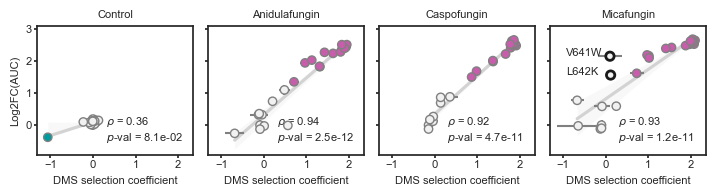

In [17]:
sns.set_theme(rc = {
              'font.family':'Arial',
              'font.size':8,
              'legend.title_fontsize':8, 'legend.fontsize':8,
              'axes.labelsize':8,'axes.titlesize':8,
              'xtick.labelsize':8, 'ytick.labelsize':8,
              'xtick.major.pad':2, 'ytick.major.pad':2,
              'xtick.bottom': True, 'ytick.left': True,
              'xtick.major.size':2, 'ytick.major.size':2,
             },
       style='ticks')

lcomp = ['none','anidulafungin','caspofungin','micafungin']
comp_dict = {'caspofungin':'Caspofungin',
             'micafungin':'Micafungin',
             'anidulafungin':'Anidulafungin',
             'none':'Control'
            }
classes = ['resistant','sensitive','deleterious']
class_palette = ['#C75DAB','#F1F1F1','#009B9E']
class_cmap = dict(zip(classes, class_palette))

# Initialize list to save linear regression parameters for each condition
reglist=[]

grid = sns.lmplot(corrdf, x='s', y='L2FC', col='compound', col_order=lcomp,
                  markers='none', # dots are redrawn with color = resistance class
                  # note: i've tried coloring the markers using scatter_kws, doesn't work
                  facet_kws={'despine':False},
                  line_kws={'color': 'lightgrey'},
                  height=2, aspect=.9
                 )

for i,c in enumerate(lcomp):
    graphdf = corrdf[corrdf.compound == c]
    grid.axes[0][i].title.set_text(comp_dict[c])
    
    # Drawing error bars
    grid.axes[0][i].errorbar(x=graphdf.s, y=graphdf.L2FC,
                   xerr=[graphdf.min_xerr, graphdf.max_xerr],
                   yerr=[graphdf.min_yerr, graphdf.max_yerr],
                   fmt='none', ecolor='grey' # only error bars, no dots
                  )
    
    # Drawing dots, colored by their classification (resistant, WT-like, etc)
    grid.axes[0][i].scatter(x=graphdf.s, y=graphdf.L2FC,
                            c=graphdf.sensres.map(class_cmap),
                            ec='grey',
                            zorder=100
                           )
    
    # Calculate and display Spearman correlation coefficient
    from scipy import stats
    sr, sp = stats.spearmanr(graphdf.s, graphdf.L2FC)
    grid.axes[0][i].text(.3, -0.5, fr'$\rho$ = {sr:.2f}'+
                         '\n$\it{p}$-val = '+f'{sp:.1e}', ha='left')
    
    # I am leaving some unused code below to compare linear regression with seaborn (statsmodels OLS) and sklearn
    # but ultimately I use the regression done by seaborn (statsmodels OLS)
    # then I fetch the slope and intercept from seaborn drawn lines and append them to a dataframe
    
    # Perform linear regression using sklearn package
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LinearRegression
    X = graphdf.s.values.reshape(-1,1)
    y = graphdf.L2FC.values.reshape(-1,1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6) # train on 20% of dataset
    reg = LinearRegression().fit(X_train, y_train)
    
    # Extract slope and intercept from sklearn Linear Regression model
    slopeSK = reg.coef_.flatten()[0]
    interceptSK = reg.intercept_[0]
    
    # Extract slope and intercept from seaborn lmplot (statsmodels OLS)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x=grid.axes[0][i].get_lines()[0].get_xdata(),
                                                                     y=grid.axes[0][i].get_lines()[0].get_ydata())
    
    # Save slope and intercept for each condition in a list -> append to master list
    reglist.append([c, slope, intercept])

# Highlighting interesting cases
int_mut = ['V641W','L642K']
deviating_df = corrdf[(corrdf.compound == 'micafungin')
                       & (corrdf.genotype.isin(int_mut))]
grid.axes[0][3].scatter(x=deviating_df.s, y=deviating_df.L2FC,
                        c=deviating_df.sensres.map(class_cmap),
                        ec='k', lw=2,
                        zorder=200
                       )
# .. and label them
for i, m in enumerate(int_mut):
    grid.axes[0][3].annotate(m, (deviating_df.s.values[i], # x
                                 deviating_df.L2FC.values[i] # y
                                ),
                             xytext = (-4,0), # distance of text label from xy coords
                             textcoords = 'offset fontsize' # xytext coords given in fontsize
                            )

grid.set_axis_labels('DMS selection coefficient', 'Log2FC(AUC)')

# Convert list of list to dataframe
regdf = pd.DataFrame(reglist, columns=['compound', 'slope', 'intercept'])

plt.savefig(f'{graph_outpath}/validations.svg', format='svg', dpi=300)

In [18]:
regdf

,compound,slope,intercept
0,none,0.423336,0.098304
1,anidulafungin,1.156112,0.321807
2,caspofungin,1.198242,0.343398
3,micafungin,0.924140,0.816973


In [19]:
def get_estimate_DMS_score(v, r, df):
    # Merge row and dataframe containing linear regression parameters
    merg = pd.merge(r.to_frame().T, df, how='left', on='compound')
    
    # Get slope and intercept for this condition
    s = merg.slope[0]
    i = merg.intercept[0]
    
    # Return corrected value
    return (v-i)/s

In [20]:
# Mutants for which we need to estimate the DMS score
mut_no_DMS = [x for x in aggdf.genotype.unique() if x not in corrdf.genotype.unique()]
print(mut_no_DMS)

['F639C', 'L640D', 'L642G', 'P647N', 'P647Q']


In [21]:
aggdf['estimated_s'] = aggdf.apply(lambda row: get_estimate_DMS_score(row.L2FC, row, regdf), axis=1)
rescued_df = aggdf[aggdf.genotype.isin(mut_no_DMS+['V641W','L642K'])]
rescued_df.to_csv(f'{df_outpath}/validation_DMS_missing_estimates.csv')
rescued_df

,genotype,aa_seq,compound,auc,auc_min,auc_max,L2FC,L2FC_min,L2FC_max,min_yerr,max_yerr,estimated_s
8,F639C,CLVLSLRDP,anidulafungin,143.19975,139.3225,147.0770,2.463986,2.424386,2.502529,0.039601,0.038543,1.852916
9,F639C,CLVLSLRDP,caspofungin,135.58750,132.0890,139.0860,2.565742,2.528028,2.602495,0.037714,0.036753,1.854670
10,F639C,CLVLSLRDP,micafungin,142.16350,135.8590,148.4680,2.561898,2.496457,2.624499,0.065441,0.062601,1.888163
11,F639C,CLVLSLRDP,none,148.17825,148.1085,148.2480,0.140449,0.139770,0.141128,0.000679,0.000679,0.099555
32,L640D,FDVLSLRDP,anidulafungin,30.37775,30.0705,30.6850,0.227044,0.212378,0.241563,0.014666,0.014519,-0.081967
33,L640D,FDVLSLRDP,caspofungin,25.44800,22.6865,28.2095,0.152142,-0.013577,0.300770,0.165718,0.148629,-0.159614
34,L640D,FDVLSLRDP,micafungin,62.52275,61.7745,63.2710,1.376800,1.359431,1.393964,0.017370,0.017163,0.605783
35,L640D,FDVLSLRDP,none,145.69875,144.7380,146.6595,0.116104,0.106559,0.125586,0.009545,0.009482,0.042047
48,L642G,FLVGSLRDP,anidulafungin,24.61900,24.6190,24.6190,-0.076199,-0.076199,-0.076199,0.000000,0.000000,-0.344262
49,L642G,FLVGSLRDP,caspofungin,26.25650,26.2565,26.2565,0.197264,0.197264,0.197264,0.000000,0.000000,-0.121957
